## Configuration Script

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# 安装最新版本Keras
# https://keras.io/
#!pip install keras
#最新版 keras==2.3.0 2020.06.27
# 指定版本安装
#!pip install keras==2.0.8
#!pip install keras==2.1.5
!pip install keras==2.1.5

%tensorflow_version 1.x
!pip install imgaug==0.2.5
!pip install gast==0.2.2

# 安装 OpenCV
# https://opencv.org/
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
# 安装 Pytorch
# http://pytorch.org/
!pip install --upgrade pip
!pip install folium==0.2.1
!pip install numpy --upgrade
!pip install torch==1.5.1
# 安装 XGBoost
# https://github.com/dmlc/xgboost
!pip install -q xgboost
# 安装 7Zip
!apt-get -qq install -y libarchive-dev && pip install -q -U libarchive
# 安装 GraphViz 和 PyDot
!apt-get -qq install -y graphviz && pip install -q pydot

#import tensorflow
#print(tensorflow.__version__)

!pip install --upgrade pip
!pip install folium==0.2.1
!pip install numpy --upgrade
!pip install torch==1.5.1

import os
#from google.colab import drive
#drive.mount('/content/drive',force_remount=True)
 
path = "/content/drive/My Drive/Colab Notebooks/Mask_RCNN-master"
os.chdir(path)

!pip install -r requirements.txt

!python setup.py install

#path = "/content/drive/My Drive/Colab Notebooks/coco-master/PythonAPI"
#os.chdir(path)

#!make

  Using cached Keras-2.1.5-py2.py3-none-any.whl (334 kB)
  Attempting uninstall: keras
    Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.2.1)
Requirement already up-to-date: numpy in /usr/local/lib/python3.6/dist-packages (1.19.1)
running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.

## Mask R-CNN


In [23]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import json
import datetime
import skimage.draw

# Root directory of the project
ROOT_DIR = os.path.abspath("../../") 
#ROOT_DIR = os.path.abspath("/content/drive/My Drive/Colab Notebooks/Mask_RCNN-master")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to dataset
dataset_dir = os.path.abspath("/content/drive/My Drive/Colab Notebooks/DIODE Dataset Backup")

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to pre-trained weights file (transfer learning)
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations


In [24]:
# Configurations
class FootpathConfig(Config):
    """Configuration for training on the footpath dataset.
    Derives from the base Config class and overrides values specific
    to the footpath dataset.
    """
    # Give the configuration a recognizable name
    NAME = "footpath"

    # Train on 1 GPU and 2 images per GPU.
    # Batch size is 2 (Batch size = GPU_COUNT * IMAGES_PER_GPU). 
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2 # use large RAM mode 12GB for two images

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 class

    STEPS_PER_EPOCH = 1000

    VALIDATION_STEPS = 50
	
	  # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    IMAGE_CHANNEL_COUNT = 3

    # Image mean (RGB)
    MEAN_PIXEL = np.array([95.2, 111.1, 40.0])
    
config = FootpathConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Dataset

In [25]:
# Dataset 
class FootpathDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_footpath(self, dataset_dir, subset):
        from tqdm import tqdm
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. 
        self.add_class("footpath", 1, "obstacles")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        files_dir = os.path.join(dataset_dir, subset)

        # Add images
        if subset == 'train':
          train_library_dir = os.path.join(dataset_dir, 'train images list.txt')
          with open(train_library_dir, mode='r') as file_object:
            contents = file_object.readlines()
            with tqdm(total=len(contents), desc=subset, leave=True, unit='img', unit_scale=True) as pbar:
              for image_name in contents:
                image_name = image_name.strip('\n')
                if image_name:
                  image_name = image_name.replace('.png', '_depth_visualization.png')
                  image_path = os.path.join(files_dir, image_name)
                  image = skimage.io.imread(image_path)
                  height, width = image.shape[:2]
                  name_ids = [1]
                  self.add_image("footpath", image_id=image_name, path=image_path, width=width, height=height, class_ids=name_ids)
                pbar.update(1)

        elif subset == 'val':
          val_library_dir = os.path.join(dataset_dir, 'val images list.txt')
          with open(val_library_dir, mode='r') as file_object:
            contents = file_object.readlines()
            with tqdm(total=len(contents), desc=subset, leave=True, unit='img', unit_scale=True) as pbar:
              for image_name in contents:
                image_name = image_name.strip('\n')
                if image_name:
                  image_name = image_name.replace('.png', '_depth_visualization.png')
                  image_path = os.path.join(files_dir, image_name)
                  image = skimage.io.imread(image_path)
                  height, width = image.shape[:2]
                  name_ids = [1]
                  self.add_image("footpath", image_id=image_name, path=image_path, width=width, height=height, class_ids=name_ids)
                pbar.update(1)
        

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """

        # If not a footpath dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "footpath":
            return super(self.__class__, self).load_mask(image_id)
        name_ids = image_info['class_ids']

        info = self.image_info[image_id]
        mask_file_id = info["id"].replace('_depth_visualization.png', '_depth_mask.npy')
        depth_visualization_image_path = info["path"]
        parent_dir = os.path.dirname(depth_visualization_image_path)
        mask_file_path = os.path.join(parent_dir, mask_file_id)
        mask = np.load(mask_file_path)
        mask = np.reshape(mask, (info["height"], info["width"], 1))

        class_ids = np.array(name_ids, dtype=np.int32)

        # Return mask, and array of class IDs of each instance.
        return mask, class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "footpath":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [26]:
# Training dataset
dataset_train = FootpathDataset()
dataset_train.load_footpath(dataset_dir, "train")
dataset_train.prepare()

# Validation dataset
dataset_val = FootpathDataset()
dataset_val.load_footpath(dataset_dir, "val")
dataset_val.prepare()


train: 100%|██████████| 4.43k/4.43k [1:01:45<00:00, 1.19img/s]
val: 100%|██████████| 771/771 [12:25<00:00, 1.03img/s]


## Create Model

In [27]:
# Create Model
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [28]:
# Which weights to start with?
# If needs to train from scratch, skip running this cell
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

Re-starting from epoch 80


## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [21]:
# Training
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
print("Training all the branches")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=40, 
            layers='all')

Training all the branches

Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/footpath20200805T2228/mask_rcnn_footpath_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bran

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/40
1000/1000 [==============================] - 930s 930ms/step - loss: 2.0275 - val_loss: 1.1975

Epoch 2/40
1000/1000 [==============================] - 881s 881ms/step - loss: 1.3403 - val_loss: 1.5246
Epoch 3/40
1000/1000 [==============================] - 880s 880ms/step - loss: 1.2869 - val_loss: 1.6720
Epoch 4/40
1000/1000 [==============================] - 881s 881ms/step - loss: 1.2586 - val_loss: 1.0307
Epoch 5/40
1000/1000 [==============================] - 879s 879ms/step - loss: 1.2544 - val_loss: 2.0450
Epoch 6/40
1000/1000 [==============================] - 881s 881ms/step - loss: 1.1710 - val_loss: 1.4876
Epoch 7/40
1000/1000 [==============================] - 878s 878ms/step - loss: 1.2073 - val_loss: 1.6470
Epoch 8/40
1000/1000 [==============================] - 878s 878ms/step - loss: 1.1080 - val_loss: 1.3457
Epoch 9/40
1000/1000 [==============================] - 877s 877ms/step - loss: 1.0888 - val_loss: 1.2694
Epoch 10/40
1000/1000 [======================

In [33]:
print("Continue to train extra epochs ")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=50, 
            layers='all')

Continue to train extra epochs 

Starting at epoch 40. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/footpath20200805T2228/mask_rcnn_footpath_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 41/50
1000/1000 [==============================] - 929s 929ms/step - loss: 0.2382 - val_loss: 0.2828
Epoch 42/50
1000/1000 [==============================] - 892s 892ms/step - loss: 0.2685 - val_loss: 0.1980
Epoch 43/50
1000/1000 [==============================] - 891s 891ms/step - loss: 0.2208 - val_loss: 0.1343
Epoch 44/50
1000/1000 [==============================] - 892s 892ms/step - loss: 0.2559 - val_loss: 0.2237
Epoch 45/50
1000/1000 [==============================] - 890s 890ms/step - loss: 0.2698 - val_loss: 0.1813
Epoch 46/50
1000/1000 [==============================] - 889s 889ms/step - loss: 0.3803 - val_loss: 0.1043
Epoch 47/50
1000/1000 [==============================] - 889s 889ms/step - loss: 0.2501 - val_loss: 2.4295
Epoch 48/50
1000/1000 [==============================] - 891s 891ms/step - loss: 0.3032 - val_loss: 1.0377
Epoch 49/50
1000/1000 [==============================] - 891s 891ms/step - loss: 0.2332 - val_loss: 0.1507
Epoch 50/50
1000/1000 [==============

In [20]:
print("Continue to train extra epochs ")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=80, 
            layers='all')

Continue to train extra epochs 

Starting at epoch 64. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/footpath20200805T2228/mask_rcnn_footpath_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the `keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 65/80
1000/1000 [==============================] - 901s 901ms/step - loss: 0.3198 - val_loss: 0.1570

Epoch 66/80
1000/1000 [==============================] - 1142s 1s/step - loss: 0.2209 - val_loss: 0.1774
Epoch 67/80
1000/1000 [==============================] - 1254s 1s/step - loss: 0.2293 - val_loss: 0.1107
Epoch 68/80
1000/1000 [==============================] - 1242s 1s/step - loss: 0.2676 - val_loss: 0.1363
Epoch 69/80
 196/1000 [====>.........................] - ETA: 15:57 - loss: 0.3383

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


1000/1000 [==============================] - 1303s 1s/step - loss: 0.2570 - val_loss: 0.1304
Epoch 70/80
1000/1000 [==============================] - 1285s 1s/step - loss: 0.1993 - val_loss: 0.1968
Epoch 71/80
1000/1000 [==============================] - 1253s 1s/step - loss: 0.2025 - val_loss: 0.2386
Epoch 72/80
1000/1000 [==============================] - 1303s 1s/step - loss: 0.2839 - val_loss: 0.1890
Epoch 73/80
1000/1000 [==============================] - 1156s 1s/step - loss: 0.2340 - val_loss: 0.2552
Epoch 74/80
1000/1000 [==============================] - 1059s 1s/step - loss: 0.2196 - val_loss: 0.1366
Epoch 75/80
1000/1000 [==============================] - 1098s 1s/step - loss: 0.2200 - val_loss: 0.1249
Epoch 76/80
1000/1000 [==============================] - 1209s 1s/step - loss: 0.2074 - val_loss: 0.0980
Epoch 77/80
1000/1000 [==============================] - 1293s 1s/step - loss: 0.2969 - val_loss: 0.1020
Epoch 78/80
1000/1000 [==============================] - 1134s 1s/s

In [ ]:
print("Continue to train extra epochs ")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=120, 
            layers='all')

Continue to train extra epochs 

Starting at epoch 80. LR=0.001

Checkpoint Path: /content/drive/My Drive/logs/footpath20200805T2228/mask_rcnn_footpath_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

Epoch 81/120
1000/1000 [==============================] - 895s 895ms/step - loss: 0.2019 - val_loss: 0.1838
Epoch 82/120
1000/1000 [==============================] - 1032s 1s/step - loss: 0.2418 - val_loss: 0.1453
Epoch 83/120
1000/1000 [==============================] - 1136s 1s/step - loss: 0.2417 - val_loss: 0.0695
Epoch 84/120
1000/1000 [==============================] - 1151s 1s/step - loss: 0.1971 - val_loss: 0.0552
Epoch 85/120
1000/1000 [==============================] - 1160s 1s/step - loss: 0.2456 - val_loss: 0.4836
Epoch 86/120
  96/1000 [=>............................] - ETA: 14:16 - loss: 0.2421

/tensorflow-1.15.2/python3.6/keras/utils/data_utils.py:718: UserWarning: An input could not be retrieved. It could be because a worker has died.We do not have any information on the lost sample.
  UserWarning)


1000/1000 [==============================] - 1272s 1s/step - loss: 0.2791 - val_loss: 0.1350
Epoch 87/120
1000/1000 [==============================] - 1192s 1s/step - loss: 0.2075 - val_loss: 0.2554
Epoch 88/120
1000/1000 [==============================] - 1121s 1s/step - loss: 0.1911 - val_loss: 0.2621
Epoch 89/120
1000/1000 [==============================] - 1066s 1s/step - loss: 0.3073 - val_loss: 0.2380
Epoch 90/120
1000/1000 [==============================] - 1136s 1s/step - loss: 0.2057 - val_loss: 0.3306
Epoch 91/120
1000/1000 [==============================] - 1243s 1s/step - loss: 0.3306 - val_loss: 0.1102
Epoch 92/120
1000/1000 [==============================] - 1294s 1s/step - loss: 0.2205 - val_loss: 0.1768
Epoch 93/120
1000/1000 [==============================] - 1229s 1s/step - loss: 0.1990 - val_loss: 0.1470
Epoch 94/120
1000/1000 [==============================] - 1259s 1s/step - loss: 0.2412 - val_loss: 0.0413
Epoch 95/120
1000/1000 [==============================] - 1

In [32]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
print("Fine-tuning all layers")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=10, 
            layers="all")

Fine-tuning all layers

Starting at epoch 40. LR=0.0001

Checkpoint Path: /content/drive/My Drive/logs/footpath20200805T2228/mask_rcnn_footpath_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branc

/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.6/keras/engine/training_generator.py:49: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers ma

In [25]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_diode_depth_pretrain.h5")
model.keras_model.save_weights(model_path)

## Detection


In [42]:
# Detection
class InferenceConfig(FootpathConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/logs/footpath20200805T2228/mask_rcnn_footpath_0050.h5
Re-starting from epoch 50


original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max: 1024.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:    0.00000  max: 1024.00000  int32
gt_mask                  shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000  float64


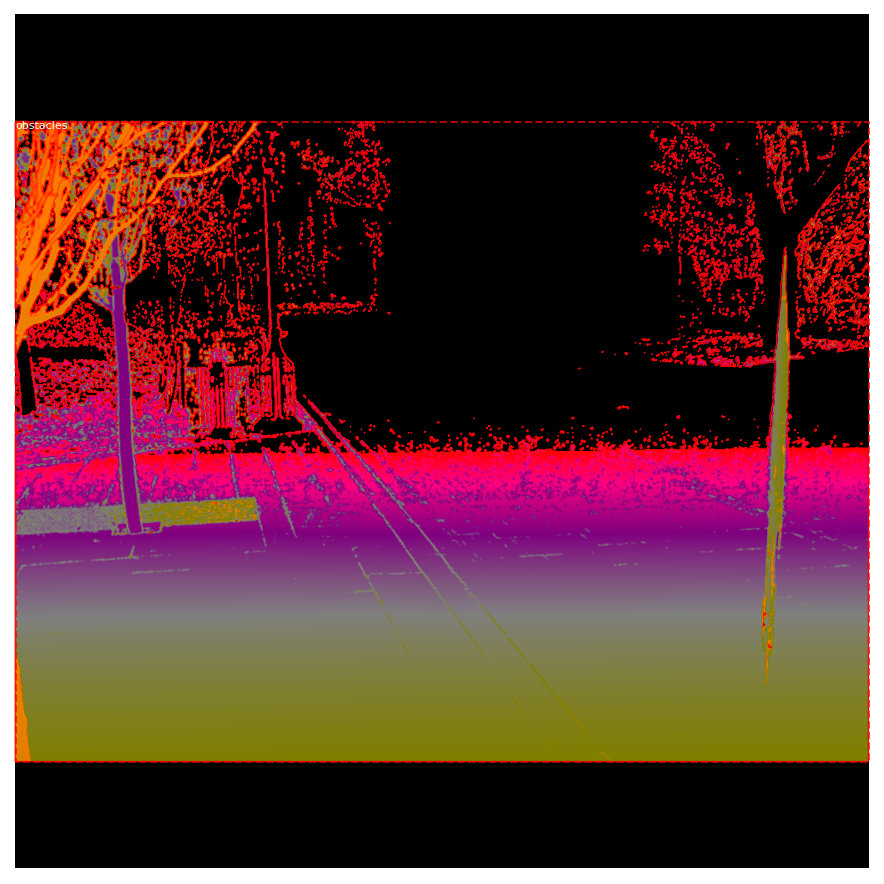

In [45]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

# Display ground truth
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, dataset_train.class_names)


Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -111.10000  max:  215.00000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


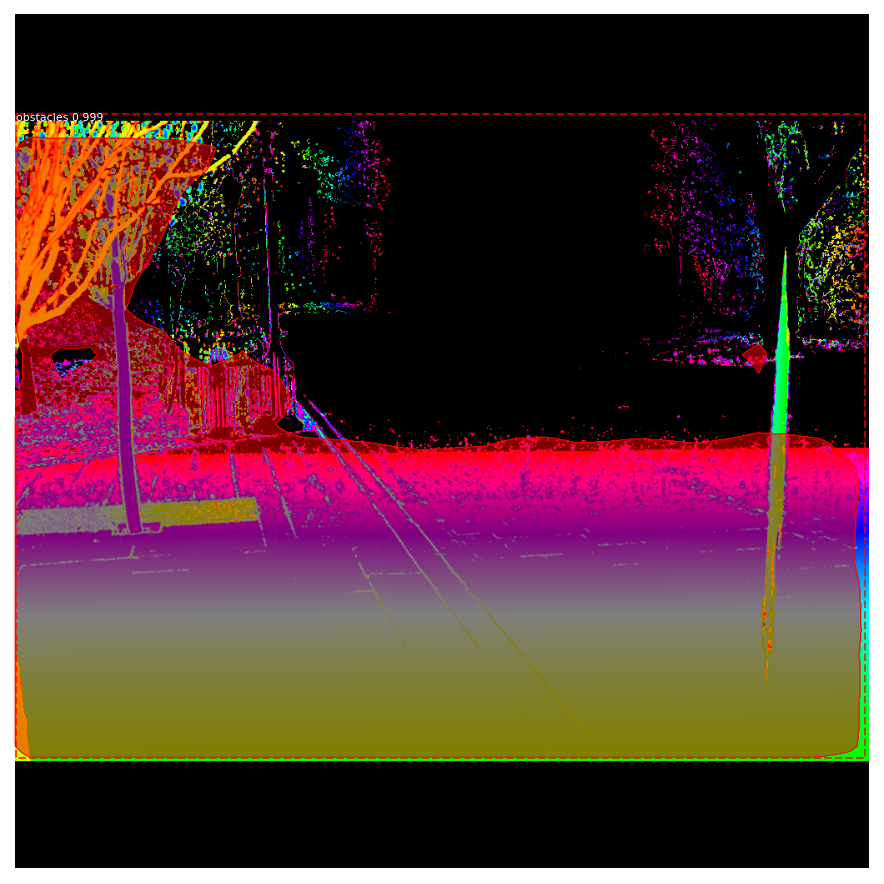

In [46]:
# Prediction(detection) results
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], dataset_val.class_names, r['scores'])


## Evaluation

In [49]:
#Evaluation
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 100)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.72
